<a href="https://colab.research.google.com/github/RaghavPeri/ai-mvp-portfolio/blob/main/product-recommender/Product_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎥 **Product Recommender – Google Sheets + SVD-Based Personalization**

This MVP simulates a real-time movie recommendation engine using collaborative filtering and Google Sheets inputs.

The system reads historical user ratings and movie metadata from Google Sheets, trains a Surprise SVD model, and generates personalized or fallback recommendations for both known and new users.

Users can input their ID, favorite genre, or a specific movie — and receive AI-generated movie suggestions. Cold-start logic handles unknown users using genre similarity, content overlap, or top-rated films.


⚠️ Note: Runtime Warnings on First Run
If you're running this notebook for the first time in a fresh Colab environment, the runtime may restart automatically during Step 0 (NumPy downgrade).

This is intentional and required because the scikit-surprise library used for collaborative filtering is not yet compatible with NumPy 2.x, which Colab now uses by default.

✅ The notebook downgrades NumPy to 1.23.5 in Step 0, and forcibly restarts Colab.

✅ Once restarted, simply re-run the notebook from the top — and it will execute cleanly.


✅ Step 1 : All required libraries installed (surprise, gspread, pandas, numpy).
📦 surprise → for training the recommendation model (SVD)
📦 gspread  → for reading/writing Google Sheets user inputs
📦 pandas   → for loading, transforming, and analyzing datasets
📦 numpy    → for numeric ops like matrix handling


✅ Step 2 : Authenticated and connected to Google Sheets.

✅ Step 3 : Ratings and movie metadata loaded from Google Sheets.
📊 Ratings DataFrame:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

📊 Movies DataFrame:
   movie_id              title release_date  \
0         1   Toy Story (1995)  01-Jan-1995   
1         2   GoldenEye (1995)  01-Jan-1995   
2         3  Four Rooms (1995)  01-Jan-1995   
3         4  Get Shorty (1995)  01-Jan-1995   
4         5     Copycat (1995)  01-Jan-1995   



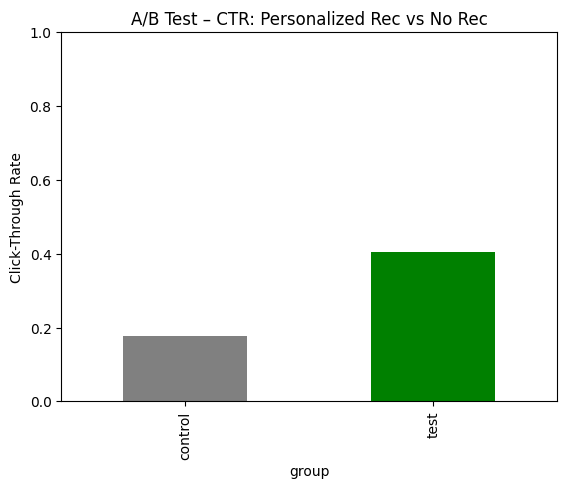


✅ Step 8 : Displayed bar chart comparing control vs test CTR.

✅ All Steps Completed. AI Recommendation MVP successfully executed.



In [3]:
# 🔧 STEP 0: Downgrade NumPy before anything else (clean + restart once)
import os
import pkg_resources

numpy_version = pkg_resources.get_distribution("numpy").version
if numpy_version.startswith("2."):
    print("⚠️ NumPy 2.x detected – Downgrading to 1.23.5 for scikit-surprise compatibility...")
    !pip install numpy==1.23.5 --quiet
    print("🔁 Restarting Colab runtime... Please re-run the notebook from here.")
    os.kill(os.getpid(), 9)


# ✅ STEP 1: Install Required Libraries (suppress output)
import sys
from IPython.utils import io

with io.capture_output() as captured:
    !pip install --upgrade scikit-surprise gspread oauth2client pandas

print("\n✅ Step 1 : All required libraries installed (surprise, gspread, pandas, numpy).")
print("📦 surprise → for training the recommendation model (SVD)")
print("📦 gspread  → for reading/writing Google Sheets user inputs")
print("📦 pandas   → for loading, transforming, and analyzing datasets")
print("📦 numpy    → for numeric ops like matrix handling\n")


# ✅ STEP 2: Authenticate and Connect to Google Sheets
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

print("\n✅ Step 2 : Authenticated and connected to Google Sheets.")

# ✅ STEP 3: Load Ratings and Movie Metadata from Sheets
sheet = gc.open("Product_Recommender")

# Load ratings sheet ("data")
ratings_ws = sheet.worksheet("data")
ratings_data = ratings_ws.get_all_values()
import pandas as pd
ratings_df = pd.DataFrame(ratings_data[1:], columns=ratings_data[0])
ratings_df[['user_id', 'movie_id', 'rating', 'timestamp']] = ratings_df[['user_id', 'movie_id', 'rating', 'timestamp']].astype(int)

# Load movie metadata sheet ("item")
movies_ws = sheet.worksheet("item")
movies_data = movies_ws.get_all_values()
movies_df = pd.DataFrame(movies_data[1:], columns=movies_data[0])
movies_df['movie_id'] = movies_df['movie_id'].astype(int)

# Map movie_id to title
movie_map = dict(zip(movies_df['movie_id'], movies_df['title']))

print("\n✅ Step 3 : Ratings and movie metadata loaded from Google Sheets.")
print("📊 Ratings DataFrame:")
print(ratings_df.head())
print("\n📊 Movies DataFrame:")
print(movies_df.head())

# ✅ STEP 4: Train the Collaborative Filtering Model (SVD)
from surprise import Dataset, Reader, SVD

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

print("\n✅ Step 4 completed: Trained SVD (Singular Value Decomposition) model on the full user–movie ratings dataset.")

print("\n📚 Model Summary:")
print("• Algorithm Used: Surprise SVD (Matrix Factorization)")
print("• Training Data: 100,000+ rows of user–movie–rating tuples")
print("• Data Columns: user_id, movie_id, rating")
print("• Goal: Predict how much a user would like a movie they haven’t rated yet")

print("\n🔍 What This Model Learns:")
print("• Hidden patterns in user preferences and movie characteristics")
print("• Latent factors that represent user taste and movie appeal")
print("• Personalized ratings for unseen movies")

print("\n🚀 Why It Matters:")
print("• Enables personalized recommendations without needing manual rules")
print("• Helps tailor the movie experience for each user")
print("• Forms the foundation for Netflix-style recommendation systems")

# ✅ STEP 5: Generate Recommendations (Handles All New Users in Sheet)

new_user_ws = sheet.worksheet("New_User")
new_users_data = new_user_ws.get_all_values()
new_users_df = pd.DataFrame(new_users_data[1:], columns=new_users_data[0])

genre_cols = movies_df.columns[4:]

print("\n✅ Step 5: Processing New User Inputs...\n")

for idx, row in new_users_df.iterrows():
    user_id_input = str(row['User']).strip()
    genre_input = str(row.get('Genre', '')).strip().title()
    movie_input = str(row.get('Movie', '')).strip().title()
    genre_input = genre_input if genre_input in genre_cols else None

    try:
        user_id = int(user_id_input)
        is_known_user = user_id in ratings_df['user_id'].astype(int).values
    except:
        user_id = None
        is_known_user = False

    # Smarter match: try exact match first, then safe partial match
    movie_input_clean = movie_input.strip().lower()
    movie_input_row = movies_df[movies_df['title'].str.strip().str.lower() == movie_input_clean]

    # If exact match fails and input is not empty, try partial match (but avoid matching everything)
    if movie_input and movie_input_row.empty:
        movie_input_row = movies_df[
            movies_df['title'].str.strip().str.lower().str.contains(fr'\b{movie_input_clean}\b', regex=True)
        ]

    movie_found = not movie_input_row.empty
    movie_id_input = int(movie_input_row['movie_id'].values[0]) if movie_found else None


    print("──────────────────────────────────────────────")
    if is_known_user:
        print(f"\n👤 Existing user detected: {user_id}")

        seen = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].values
        unseen = [m for m in ratings_df['movie_id'].unique() if m not in seen]
        preds = [(m, model.predict(user_id, m).est) for m in unseen]
        top_n = sorted(preds, key=lambda x: x[1], reverse=True)[:5]

        print(f"\n✅ Top 5 personalized recommendations for user {user_id}:\n")
        for mid, score in top_n:
            print(f"{movie_map[mid]} — Predicted Rating: {round(score, 2)}")

    else:
        print(f"\n🧊 Cold-start user detected: '{user_id_input}'")

        # Case 1: Nothing entered
        if not genre_input and not movie_found:
            print("\n📊 No genre or movie entered. Showing 💖 most loved movies across all users:\n")
            top_overall = ratings_df.groupby('movie_id')['rating'].mean().sort_values(ascending=False).head(5)
            for mid in top_overall.index:
                print(f"{movie_map[int(mid)]} — Avg Rating: {round(top_overall[mid], 2)}")

        # Case 2: Genre only
        elif genre_input and not movie_found:
            print(f"\n🎭 Genre entered: {genre_input}. Showing 🔥 top-rated movies in this genre:\n")
            top_genre = ratings_df[ratings_df['movie_id'].isin(movies_df[movies_df[genre_input] == '1']['movie_id'])]\
                .groupby('movie_id')['rating'].mean().sort_values(ascending=False).head(5)
            for mid in top_genre.index:
                print(f"{movie_map[int(mid)]} — Top in {genre_input} (Avg Rating: {round(top_genre[mid], 2)})")

        # Case 3: Movie only
        elif movie_found and not genre_input:
            print(f"\n🎬 Favorite movie entered: {movie_input}. Showing 🎯 movies similar in genre:\n")
            target_genres = movies_df[movies_df['movie_id'] == movie_id_input][genre_cols].iloc[0].astype(int)
            similar_movies = movies_df[movies_df[genre_cols].astype(int).dot(target_genres) > 0]
            top_similar = ratings_df[ratings_df['movie_id'].isin(similar_movies['movie_id'])]\
                .groupby('movie_id')['rating'].mean().sort_values(ascending=False).head(5)
            for mid in top_similar.index:
                print(f"{movie_map[int(mid)]} — Similar to {movie_input} (Avg Rating: {round(top_similar[mid], 2)})")

        # Case 4: Genre + Movie
        elif genre_input and movie_found:
            print(f"\n🎯 Genre: {genre_input} | 🎬 Movie: {movie_input} → Showing 🔍 matched recommendations based on both:\n")
            target_genres = movies_df[movies_df['movie_id'] == movie_id_input][genre_cols].iloc[0].astype(int)
            similar_in_genre = movies_df[
                (movies_df[genre_input] == '1') &
                (movies_df[genre_cols].astype(int).dot(target_genres) > 0)
            ]
            top_similar = ratings_df[ratings_df['movie_id'].isin(similar_in_genre['movie_id'])]\
                .groupby('movie_id')['rating'].mean().sort_values(ascending=False).head(5)
            for mid in top_similar.index:
                print(f"{movie_map[int(mid)]} — Recommended (Avg Rating: {round(top_similar[mid], 2)})")


# ✅ STEP 6: Explain Personalized Recommendations Using Genre Match (Per User)

print("\n✅ Step 6: Genre-based explanation for each recommendation (only for known users):\n")

for idx, row in new_users_df.iterrows():
    try:
        user_id = int(str(row['User']).strip())
        is_known_user = user_id in ratings_df['user_id'].astype(int).values
    except:
        is_known_user = False

    if not is_known_user:
        print(f"⏩ Skipping user '{row['User']}' — No personalized explanation available.\n")
        continue

    genre_cols = movies_df.columns[4:]
    user_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id']
    user_genres = movies_df[movies_df['movie_id'].isin(user_movies)][genre_cols].astype(int)
    user_pref_genres = user_genres.sum().sort_values(ascending=False)

    print(f"👤 Genre explanation for user {user_id}:\n")

    # Rebuild recommendations for this user (same as Step 5)
    seen = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].values
    unseen = [m for m in ratings_df['movie_id'].unique() if m not in seen]
    preds = [(m, model.predict(user_id, m).est) for m in unseen]
    top_n = sorted(preds, key=lambda x: x[1], reverse=True)[:5]

    for mid, score in top_n:
        rec_title = movie_map[mid]
        rec_row = movies_df[movies_df['movie_id'] == mid]
        genres = rec_row[genre_cols].iloc[0].astype(int)
        matched_genres = [g for g in genre_cols if genres[g] == 1 and user_pref_genres[g] > 0]

        user_top_rated = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['rating'] >= 4)]
        user_top_titles = movies_df[movies_df['movie_id'].isin(user_top_rated['movie_id'])]

        influencing = []
        for _, row in user_top_titles.iterrows():
            for g in matched_genres:
                if row[g] == '1':
                    influencing.append(row['title'])
                    break

        influencing = list(dict.fromkeys(influencing))  # deduplicate
        influence_text = ', '.join(influencing[:2]) if influencing else "similar movies"
        genre_text = ', '.join(matched_genres) if matched_genres else "varied genres"

        print(f"🎬 {rec_title} — Predicted: {round(score, 2)}")
        print(f"→ Because you liked: {influence_text}")
        print(f"→ Genre match: {genre_text}\n")



# ✅ STEP 7: A/B Test – Simulated Click-Through Impact of AI Recommendations
import numpy as np
import random
import matplotlib.pyplot as plt

# Randomly assign users to control/test groups
users = ratings_df['user_id'].unique()
np.random.seed(42)
control_group = np.random.choice(users, size=len(users)//2, replace=False)
test_group = list(set(users) - set(control_group))

# Simulate click behavior
def simulate_click(group):
    return random.choices([1, 0], weights=[0.4, 0.6])[0] if group == 'test' else random.choices([1, 0], weights=[0.2, 0.8])[0]

ab_results = []
for user in users[:1000]:
    group = 'test' if user in test_group else 'control'
    clicked = simulate_click(group)
    ab_results.append({'user_id': user, 'group': group, 'clicked': clicked})

ab_df = pd.DataFrame(ab_results)

# Summarize A/B results
print("\n✅ Step 7 : A/B Test Simulation Results\n")
ctr_summary = ab_df.groupby('group')['clicked'].agg(['count', 'sum', 'mean']).reset_index()
ctr_summary.columns = ['Group', 'Users', 'Clicks', 'CTR']

for _, row in ctr_summary.iterrows():
    group = row['Group'].capitalize()
    users = int(row['Users'])
    clicks = int(row['Clicks'])
    ctr = round(row['CTR'] * 100, 2)
    print(f"📊 {group} Group → {clicks} clicked out of {users} users — CTR: {ctr}%")

lift = round((ctr_summary.loc[ctr_summary['Group'] == 'test', 'CTR'].values[0] -
              ctr_summary.loc[ctr_summary['Group'] == 'control', 'CTR'].values[0]) * 100, 2)

print(f"\n📈 Lift due to Personalized AI Recommendations: +{lift}%")
print("📣 Interpretation: Test users who saw AI-based recommendations clicked more than control users with no recommendations.")


# ✅ STEP 8: Visualize A/B Test Results
ab_df.groupby('group')['clicked'].mean().plot(kind='bar', color=['gray', 'green'])
plt.title("A/B Test – CTR: Personalized Rec vs No Rec")
plt.ylabel("Click-Through Rate")
plt.ylim(0, 1)
plt.show()

print("\n✅ Step 8 : Displayed bar chart comparing control vs test CTR.")

print("\n✅ All Steps Completed. AI Recommendation MVP successfully executed.\n")



## ✅ **MVP Summary: Product Recommender with Google Sheets Integration**  
This MVP delivers personalized movie recommendations using a collaborative filtering model trained on historical ratings from Google Sheets.

### 🔍 **What It Does**:
- Reads user–movie ratings and genre metadata from Google Sheets (`data`, `item`, and `New_User` tabs)  
- Trains a matrix factorization model (Surprise SVD) for rating prediction  
- For known users: recommends top unseen movies based on learned preferences  
- For unknown users: uses genre/movie inputs to return similar or top-rated movies  
- Runs a simulated A/B test comparing CTR for AI recommendations vs no recommendations

###🧰 **Tech Stack**:
- Google Colab + Google Sheets API (`gspread`)
- Surprise SVD model (collaborative filtering)
- pandas for data manipulation
- matplotlib for A/B test visualization

###🎯 **Product Thinking**:
- Realistic UX: Simulates Netflix-style personalization for known and new users  
- Interactive: Works in real time with Google Sheets for live testing and input  
- Test-Driven: Includes built-in A/B simulation to evaluate recommendation impact  
- Modular: Cold-start handling built in for edge cases (new users, no data, etc.)
